# Simple Jax (vmap) NN from Scratch

This notebook demonstrates vmap usage applied to the jax_basic_nn notebook. vmap conveniently converts functions designed to process a single example to process a batch without changing any of the original functions code. The original functions were already vectorized before, so it wasnt necessary in this case, but it can be powerful when working with more complicated networks.


In [171]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
from jax import nn
from jax import vmap
from keras.utils import data_utils

Check if the training data exists. If not, automatically download it.

In [172]:
data_dir = os.path.abspath("./digit-recognizer")
os.makedirs(data_dir, exist_ok=True)
train_data_path = f"{data_dir}/train.csv"
train_data_url = "https://huggingface.co/datasets/ChristianOrr/mnist/resolve/main/train.csv"

if not os.path.exists(train_data_path):
    print("Downloading training data...")
    data_utils.get_file(train_data_path, train_data_url)

data_df = pd.read_csv('./digit-recognizer/train.csv')

In [173]:
np.random.shuffle(data_df.values)
m, n = data_df.shape
Y = jnp.array(data_df["label"])
data_df = data_df.drop("label", axis=1)
X = jnp.array(data_df)


X_train = X[1000:]
X_train = X_train / 255.
Y_train = Y[1000:]

X_val = X[:1000]
X_val = X_val / 255.
Y_val = Y[:1000]

Our NN will have a simple two-layer architecture. Input layer $A^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $A^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $A^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.


**Forward propagation**

Input Layer:    
$$X = A^{[0]}$$

First Hidden Layer:
$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]})$$

Second Hidden Layer:
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

Loss Function (Categorical Cross Entropy):  
$$L(y, a^{[2]}) = -\sum_{j = 1}^{C}y_{j} \cdot\ log(a^{[2]})$$ 
C is the number of classes, which is 10 in this case. 

Cost Function:
$$J(W, b) = -\frac{1}{m} \sum_{i = 1}^{m} L(y^{i}, a^{[2](i)})$$ 
$$J(W, b) = -\frac{1}{m} \sum_{i = 1}^{m} \sum_{j = 1}^{C}y^{i}_{j}\cdot\log(a^{[2](i)})$$ 
The cost function is the average of the losses over all the samples.

Derivatives:    
For detailed derivation of $dZ^{[2]}$ see: [derivation-of-categorical-cross-entropy-loss](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1)    
For more details on the rest of the derivations see: [backpropagation-intuition](https://www.youtube.com/watch?v=yXcQ4B-YSjQ&list=PLkDaE6sCZn6Ec-XTbcX1uRg2_u4xOEky0&index=34&ab_channel=DeepLearningAI)
$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \sum_{i = 1}^{m} {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \sum_{i = 1}^{m} {dZ^{[1]}}$$

**Gradient Descent (parameter updates)**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [174]:
def init_params():
    key = random.PRNGKey(42)
    key, *subkey = random.split(key, 5)
    W1 = random.uniform(subkey[0], (10, 784), jnp.float32, -0.5, 0.5)
    b1 = random.uniform(subkey[1], (10,), jnp.float32, -0.5, 0.5)
    W2 = random.uniform(subkey[2], (10, 10), jnp.float32, -0.5, 0.5)
    b2 = random.uniform(subkey[3], (10,), jnp.float32, -0.5, 0.5)
    return W1, b1, W2, b2

def ReLU(Z):
    return jnp.maximum(Z, 0)

def softmax(Z):
    A = jnp.exp(Z) / sum(jnp.exp(Z))
    return A   

def forward(W1, b1, W2, b2, x):
    # single example forward pass
    z1 = W1.dot(x) + b1
    a1 = ReLU(z1)
    z2 = W2.dot(a1) + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2


The forward pass on a single example:

In [175]:
single_example = X_train[0]
W1, b1, W2, b2 = init_params()
_, _, _, preds = forward(W1, b1, W2, b2, single_example)
print(f"Predictions: {preds}")
print(f"Predictions shape: {preds.shape}")

Predictions: [0.00286982 0.08058164 0.04906153 0.2134403  0.02629469 0.01044182
 0.07386433 0.11316939 0.25112593 0.17915054]
Predictions shape: (10,)


The forward pass function is then converted to a vectorized function with the batch dimension added to index 0.

In [176]:
batched_forward = vmap(forward, in_axes=(None, None, None, None, 0))

vmap forward pass function inferencing a batch of data:

In [177]:
batch_example = X_train[0:4]
W1, b1, W2, b2 = init_params()
_, _, _, preds = batched_forward(W1, b1, W2, b2, batch_example)
print(f"Predictions: {preds}")
print(f"Predictions shape: {preds.shape}")

Predictions: [[0.00286505 0.08054692 0.04903826 0.21344669 0.02629639 0.01042962
  0.07381347 0.11320313 0.25126523 0.1790952 ]
 [0.01434074 0.11218907 0.02713755 0.11450128 0.01197401 0.06198742
  0.3319997  0.00577655 0.12728146 0.1928122 ]
 [0.00866232 0.16782624 0.06137933 0.12333167 0.00613823 0.00790481
  0.01294925 0.1965233  0.01287689 0.402408  ]
 [0.00224681 0.13298076 0.02585589 0.13354686 0.00634344 0.01669846
  0.29361272 0.0054402  0.11147139 0.27180347]]
Predictions shape: (4, 10)


Backward prop function has been altered to accomodate the batch being on axis 0

In [178]:
def ReLU_deriv(Z):
    return Z > 0

def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y, 10)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.T.dot(A1)
    db2 = 1 / m * jnp.sum(dZ2)
    dZ1 = W2.dot(dZ2.T).T * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.T.dot(X)
    db1 = 1 / m * jnp.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2


In [179]:
def get_predictions(A2):
    return jnp.argmax(A2, axis=1)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return jnp.mean(predictions == Y)

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = batched_forward(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [180]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[8 6 9 ... 6 6 3] [7 0 2 ... 8 8 1]
0.10958536
Iteration:  10
[7 2 7 ... 8 2 3] [7 0 2 ... 8 8 1]
0.22117072
Iteration:  20
[7 0 7 ... 8 2 5] [7 0 2 ... 8 8 1]
0.30014634
Iteration:  30
[7 0 9 ... 8 2 5] [7 0 2 ... 8 8 1]
0.373
Iteration:  40
[7 0 9 ... 8 2 1] [7 0 2 ... 8 8 1]
0.43426827
Iteration:  50
[7 0 9 ... 2 2 1] [7 0 2 ... 8 8 1]
0.47087803
Iteration:  60
[7 0 9 ... 2 2 1] [7 0 2 ... 8 8 1]
0.49802437
Iteration:  70
[7 0 9 ... 2 2 1] [7 0 2 ... 8 8 1]
0.52034146
Iteration:  80
[7 0 9 ... 2 2 1] [7 0 2 ... 8 8 1]
0.53907317
Iteration:  90
[7 0 6 ... 8 2 1] [7 0 2 ... 8 8 1]
0.557878
Iteration:  100
[7 0 6 ... 8 8 1] [7 0 2 ... 8 8 1]
0.5761463
Iteration:  110
[7 0 6 ... 8 8 1] [7 0 2 ... 8 8 1]
0.5935854
Iteration:  120
[7 0 6 ... 8 8 1] [7 0 2 ... 8 8 1]
0.61317074
Iteration:  130
[7 0 6 ... 8 8 1] [7 0 2 ... 8 8 1]
0.63314635
Iteration:  140
[7 0 6 ... 8 8 1] [7 0 2 ... 8 8 1]
0.65002435
Iteration:  150
[7 0 6 ... 8 8 1] [7 0 2 ... 8 8 1]
0.6670244
Iteration:  1

In [181]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = batched_forward(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[None, index]
    prediction = make_predictions(X_train[None, index], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [7]
Label:  7


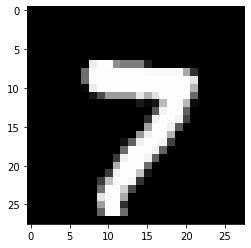

Prediction:  [0]
Label:  0


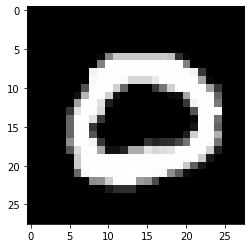

Prediction:  [9]
Label:  2


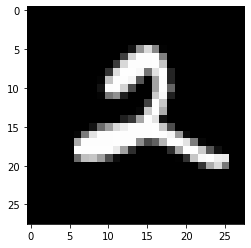

Prediction:  [9]
Label:  4


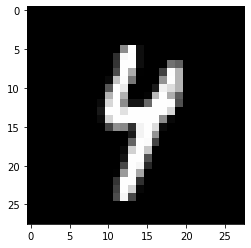

In [182]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [183]:
val_predictions = make_predictions(X_val, W1, b1, W2, b2)
get_accuracy(val_predictions, Y_val)

[7 3 4 4 6 9 4 2 0 0 2 5 5 8 3 8 1 5 1 2 9 8 4 9 4 4 5 3 4 1 9 6 8 0 1 5 0
 3 9 1 3 5 0 4 0 3 8 2 2 1 6 9 7 6 8 1 6 9 6 8 3 1 0 1 7 5 7 7 1 6 3 1 2 0
 3 2 5 3 0 2 0 2 5 1 8 1 8 4 0 0 3 3 8 1 6 1 6 9 3 0 5 9 9 1 1 0 9 1 9 9 3
 1 5 1 5 7 8 1 6 9 5 1 5 2 2 4 0 3 6 6 2 4 9 6 2 2 4 2 9 8 0 4 3 2 0 6 0 7
 8 1 0 1 6 1 6 4 1 2 4 6 7 1 7 1 8 4 9 2 2 4 5 5 8 9 9 3 0 5 4 6 2 5 4 2 2
 1 0 7 4 8 4 9 9 4 5 4 1 3 9 2 8 2 8 2 7 1 0 4 4 2 0 4 0 9 5 8 8 3 4 7 7 0
 1 3 8 4 7 6 6 8 5 4 2 8 2 0 7 7 4 5 0 3 1 8 3 6 5 7 7 4 1 6 8 1 1 9 7 1 9
 0 7 4 7 9 9 1 8 9 1 8 2 7 6 9 2 0 3 0 7 9 7 5 7 4 2 1 8 3 3 0 3 3 9 5 7 1
 1 9 9 9 8 9 7 8 2 7 8 3 3 7 7 7 7 5 6 6 0 0 5 5 2 2 8 9 4 5 7 9 2 9 9 1 1
 7 8 7 4 3 9 9 2 3 9 4 8 8 0 0 2 4 3 1 3 3 9 5 6 8 4 7 4 7 7 3 0 0 3 8 5 9
 0 9 4 7 4 8 3 2 0 6 3 2 1 6 1 0 9 4 7 3 6 4 1 3 7 7 4 4 3 4 5 3 8 0 6 1 8
 7 1 1 0 1 4 7 7 0 9 6 9 9 0 1 9 8 6 1 7 0 1 6 1 9 2 7 5 6 4 6 3 6 0 6 2 0
 1 9 3 3 7 1 7 8 7 8 0 8 8 1 6 6 2 9 4 2 1 5 3 8 7 3 9 7 6 4 8 1 1 4 1 2 9
 0 2 7 6 1 1 6 6 5 4 1 3 

DeviceArray(0.832, dtype=float32)

Accuracy is almost identical to the numpy implementation. 

### Conclusion

vmap offers a powerful option for turning single example functions into batched functions without having to redo the functions from scratch.